
# CEWA 568 Snow Hydrology - Spring 2023
## Lab 4-1-long: Downloading and plotting snow flux and wind speed data at Kettle Ponds

Written by Eli Schwat (elilouis@uw.edu) - April 2023

---

## Library imports

In [1]:
# import libraries we'll need
import urllib
import pandas as pd
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import os
%matplotlib inline

## User-provided inputs

Here we define a few variables to be used in the notebook. You may or may not want to change these values.

In [2]:
# Provide the path to a directory you want to download the SoS files to
download_directory = "../data/sosnoqc"

# Provide the paths to the precipitation file. This file was provided to you, you can either
# specify the path below or put the file in the same directory as this notebook.
precipitation_file = 'precipitation.nc'

# Provide a the start and end dates you want to download
start_date = '20221201'
end_date = '20230327'

# Provide the specific variables you want to extract from the dataset.
# We provide these in advance because the datasets are very large and, 
# when we open them, we want to immediately extract only the data we want.
VARIABLES = [
    'spd_1m_ue',
    'spd_3m_ue',
    'spd_10m_ue',
    'SF_avg_1m_ue',
    'SF_avg_2m_ue'
]

## Download and open SoS Data

### Download SoS NetCDF files from an NCAR FTP server

Define a function for downloading daily SoS NetCDF filesm

In [3]:
def download_sos_data_day(date, local_download_dir, cache=True):
    """Download a netcdf file from the ftp url provided by the Earth Observing 
    Laboratory at NCAR. Data comes in one NetCDF file per day, Reynolds-Averaged 
    with a 5-minute averaging period.

    Args:
        date (str, optional): String representing a date in format '%Y%m%d'. Defaults to '20221101'.
        local_download_dir (str, optional): Directory to which files will be downloaded. Defaults 
                    to 'sosnoqc'; this directory will be created if it  does not already exist.
        cache (bool, optional): If True, looks in `local_download_dir` for requested  file, if it 
                    exists, does not redownload file. If False, downloads file from the FTP server.

    Returns:
        _type_: Relative path to the downloaded file
    """
    base_url = 'ftp.eol.ucar.edu'
    path = 'pub/archive/isfs/projects/SOS/netcdf/noqc_geo'
    file = f'isfs_{date}.nc'
    os.makedirs(local_download_dir, exist_ok=True)
    full_file_path = os.path.join('ftp://', base_url, path, file)
    download_file_path = os.path.join(local_download_dir, file)
    if cache and os.path.isfile(download_file_path):
        print(f"Caching...skipping download for {date}")
    else:
        urllib.request.urlretrieve(
            full_file_path,
            download_file_path   
        )
    return download_file_path

Use the function defined above to download all the files we specified. When you run the cell below this comment, this will ~3-5 minutes if you are downloading more than a few days.

In [4]:
# Create a list of datetime objects for every day between the provided start_date and end_date. 
datelist = pd.date_range(
    dt.datetime.strptime(start_date, '%Y%m%d'),
    dt.datetime.strptime(end_date, '%Y%m%d'),
    freq='d'
).strftime('%Y%m%d').tolist()

# Download one daily file for each date in the datelist. 
# cache = True so that when we rerun the notebook in the future, we don't have to redownload the data.
files = [download_sos_data_day(date, download_directory, cache=True) for date in datelist]

### Open and and concatenate SoS datasets with Xarray

Note that as we open each individual file, we extract only the VARIABLES we defined above.  This may also take some time.

In [5]:
# Open up one day's dataset. We open this single dataset and keep all variables, so we can check out all that is available
example_complete_dataset = xr.open_dataset(files[0])

# Open up datasets from every day, extracting our VARIABLES of choice as we open individual datasets. This is so that we have a smaller dataset held 
# in computer memory.
all_datasets = [xr.open_dataset(file)[VARIABLES] for file in files]
sos_dataset = xr.concat(all_datasets, dim='time')

#### Check out our SoS dataset

Note that our `dataset` has just the variables we are defined. Note that `example_complete_dataset` has 1047 variables.

In [6]:
sos_dataset

<xarray.Dataset>
Dimensions:       (time: 33696)
Coordinates:
  * time          (time) datetime64[ns] 2022-12-01T00:02:30 ... 2023-03-27T23...
Data variables:
    spd_1m_ue     (time) float32 1.244 1.119 1.642 1.779 ... 3.037 2.988 4.307
    spd_3m_ue     (time) float32 1.267 0.9681 1.969 2.044 ... 4.315 4.057 6.092
    spd_10m_ue    (time) float32 1.299 0.6545 1.601 1.553 ... 5.375 4.718 5.816
    SF_avg_1m_ue  (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SF_avg_2m_ue  (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.02 0.0 0.01 0.02
Attributes:
    history:                   Created: 2022-12-01 00:05:06 +0000\n
    NIDAS_version:             v1.2-1692
    calibration_file_path:     /h/eol/isfs/isfs/projects/SOS/ISFS/cal_files/n...
    project_config:            /h/eol/isfs/isfs/projects/SOS/ISFS/config/sos....
    wind3d_horiz_coordinates:  geographic
    file_length_seconds:       86400
    wind3d_horiz_rotation:     1
    wind3d_tilt_correction:    0

## Plot
We use the Matplotlib library because integrates nicely with Xarray and makes creating simple plots quickly an easy task.

Before plotting, we resample the SoS dataset by finding the hourly mean. We don't need the high-rate (5 minute) data to look at season long changes. Also, the snow pillow dataset has lots of nans so resampling makes the plot look better. The precipitaton dataset is already daily, so we don't need to resample it.

In [7]:
sos_dataset_60min = sos_dataset.resample(time="60Min").mean()

In [8]:
# and we want to save this for people who do not want to wait for lots of data to download.
sos_dataset_60min.to_netcdf("sos_wind_snowflux.nc")

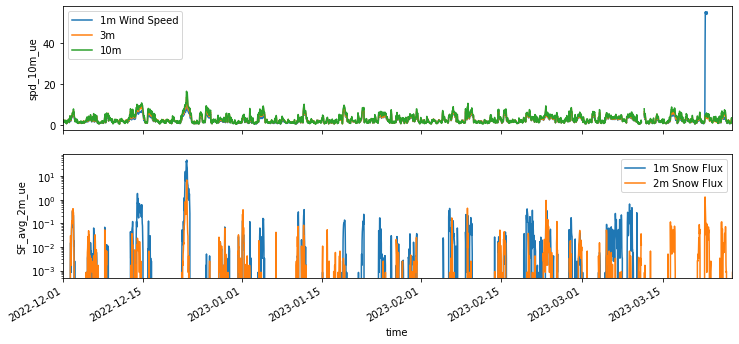

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(12,5), sharex=True)
sos_dataset_60min['spd_1m_ue'].plot(ax=axes[0], label='1m Wind Speed')
sos_dataset_60min['spd_3m_ue'].plot(ax=axes[0], label='3m')
sos_dataset_60min['spd_10m_ue'].plot(ax=axes[0], label='10m')
sos_dataset_60min['SF_avg_1m_ue'].plot(ax=axes[1], label='1m Snow Flux')
sos_dataset_60min['SF_avg_2m_ue'].plot(ax=axes[1], label='2m Snow Flux')
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("")
axes[1].set_yscale("log")
axes[0].set_xlim(dt.datetime(2022,12,1), dt.datetime(2023,3,27))
plt.show()

Note the probably-not-real measurement towards the end of our time series. We can filter and interpolate outliers to rmeove this datapoint

In [10]:
def filter_outliers(data, perc=0.99):
  # calculate percentile 
  threshold = data.quantile(perc)
  # find outliers and replace them with max among remaining values 
  mask = data.where(abs(data) <= threshold)
  # max_value = mask.max().values
  # .where replace outliers with nan
  # mask = mask.fillna(max_value)
  data = mask
  return data

sos_dataset_60min['spd_1m_ue'] = filter_outliers(sos_dataset_60min['spd_1m_ue']).interp()

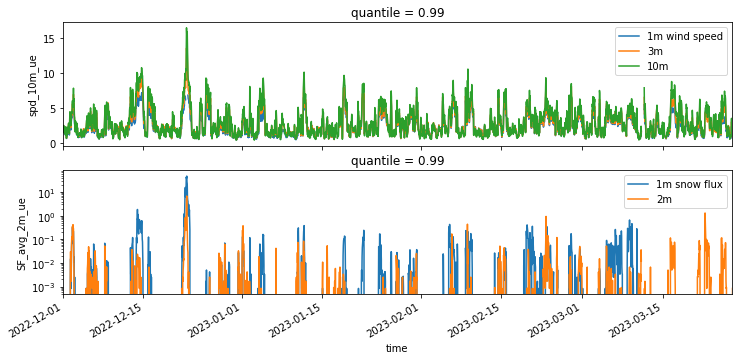

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(12,5), sharex=True)
sos_dataset_60min['spd_1m_ue'].plot(ax=axes[0], label='1m wind speed')
sos_dataset_60min['spd_3m_ue'].plot(ax=axes[0], label='3m')
sos_dataset_60min['spd_10m_ue'].plot(ax=axes[0], label='10m')
sos_dataset_60min['SF_avg_1m_ue'].plot(ax=axes[1], label='1m snow flux')
sos_dataset_60min['SF_avg_2m_ue'].plot(ax=axes[1], label='2m')
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("")
axes[1].set_yscale("log")
axes[0].set_xlim(dt.datetime(2022,12,1), dt.datetime(2023,3,27))
plt.show()